In [1]:
# Import libraries

from copy import copy
import json

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score

import shap

from scipy.stats import spearmanr

import xgboost as xgb

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from feature_importance_utils import  load_dataset, do_hyperparams_gridsearch, plot_RFE, plot_mse_r2_training, plot_importance_barchart

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load labels for plots

with open("dict_trait_names.json", 'r') as file:
    dict_trait_names = json.load(file)
file.close()    

with open("traits_categories_labels.json", 'r') as file:
    traits_categories_labels = json.load(file)
file.close()
    
with open("communities_attr.json", 'r') as file:
    communities_attr = json.load(file)
file.close()

In [3]:
# Load and preprocess input file

filename = 'drought_withnans_relchange_1-13-2025_all_nanmedian_noOutliers.csv'
X, y, traits = load_dataset(filename)

print(X.shape, y.shape)    

Removed traits because unique values: ['CDL_SOYBEANS']
(165, 249) (165,)


In [4]:
# Load precomputed values for hyperparameter optimization and Recursive Feature Elimination (RFE)
# Running these parts of the workflow will overwrite the variables values

with open('results_drought_withnans_relchange_1-13-2025_all_nanmedian_noOutliers_shapley.json', 'r') as file:
    results = json.load(file)
file.close()

params = results["params_gridsearch"]
params_RFE = results["params_RFE_gridsearch"]
rmse_ave_RFE = results["rmse_ave_RFE"] 
r2_ave_RFE = results["r2_ave_RFE"]
dict_traits_ = {int(i):j for i,j in results["dict_traits"].items()}
x_RFE = results["x_RFE"]

In [5]:
# Uncomment to perform hyperparameters optimization.
# It may take up to one hour.

#params = do_hyperparams_gridsearch(X, y)

print(params)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'reg_alpha': 0, 'reg_lambda': 0}


In [6]:
# Uncomment the entire cell to perform Recursive Features Elimination (RFE).
# It will take about 10-15 minutes.

"""
rmse_ave_RFE = []
r2_ave_RFE = []
dict_traits_ = {}
X_ = copy(X)
traits_ = traits.tolist()
x_RFE = []

while X_.shape[1]>0:
    
    if X_.shape[1]>100:
        num_elim = 10; num_runs = 10; n_repeats = 30
    elif X_.shape[1]>50:
        num_elim = 5; num_runs = 30; n_repeats = 30
    else:
        num_elim = 1; num_runs = 50; n_repeats = 30

    print("Current number features:", X_.shape[1])
    rmse_i = []
    r2_i = []
    feature_importance_rank = []
    for run in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=run+1)

        reg = xgb.XGBRegressor(**params, random_state=42)
        reg.fit(X_train, y_train)

        explainer = shap.TreeExplainer(reg)
        shap_values = explainer.shap_values(X_test)
        shap_values_means = np.nanmean(np.abs(shap_values), axis=0)
        feat_imp_means = shap_values_means/np.sum(shap_values_means)

        feature_importance_rank.append(np.argsort(np.argsort(feat_imp_means)).tolist())

        xgb_pred = reg.predict(X_test)
        rmse_i.append(mean_squared_error(y_test, xgb_pred, squared=False))
        r2_i.append(r2_score(y_test.flatten(), xgb_pred))

    feature_importance_rank = np.mean(np.array(feature_importance_rank), axis=0)
    rmse_ave_RFE.append(np.mean(rmse_i))
    r2_ave_RFE.append(np.mean(r2_i))
    print("RMSE test, R^2 test:", rmse_ave_RFE[-1], r2_ave_RFE[-1])
    dict_traits_[X_.shape[1]] = tuple(traits_)
    x_RFE.append(X_.shape[1])

    idxs_elim = np.argsort(feature_importance_rank)[:num_elim]
    X_ = X_[:, [j for j in range(X_.shape[1]) if j not in idxs_elim]]
    traits_ = [traits_[j] for j in range(len(traits_)) if j not in idxs_elim]
    
rmse_ave_RFE = rmse_ave_RFE[::-1]
r2_ave_RFE = r2_ave_RFE[::-1]
x_RFE = x_RFE[::-1]
"""

'\nrmse_ave_RFE = []\nr2_ave_RFE = []\ndict_traits_ = {}\nX_ = copy(X)\ntraits_ = traits.tolist()\nx_RFE = []\n\nwhile X_.shape[1]>0:\n    \n    if X_.shape[1]>100:\n        num_elim = 10; num_runs = 10; n_repeats = 30\n    elif X_.shape[1]>50:\n        num_elim = 5; num_runs = 30; n_repeats = 30\n    else:\n        num_elim = 1; num_runs = 50; n_repeats = 30\n\n    print("Current number features:", X_.shape[1])\n    rmse_i = []\n    r2_i = []\n    feature_importance_rank = []\n    for run in range(num_runs):\n        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=run+1)\n\n        reg = xgb.XGBRegressor(**params, random_state=42)\n        reg.fit(X_train, y_train)\n\n        explainer = shap.TreeExplainer(reg)\n        shap_values = explainer.shap_values(X_test)\n        shap_values_means = np.nanmean(np.abs(shap_values), axis=0)\n        feat_imp_means = shap_values_means/np.sum(shap_values_means)\n\n        feature_importance_rank.append(np.ar

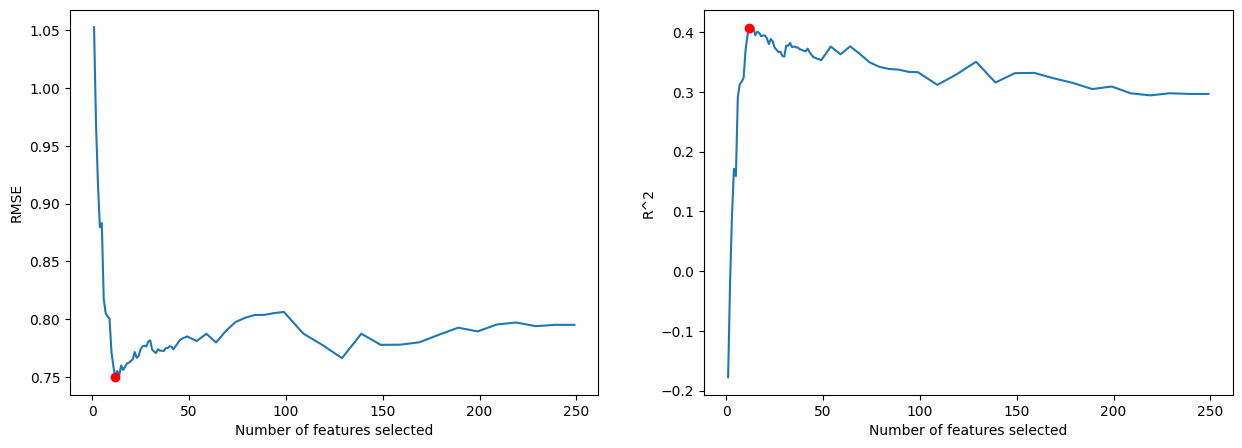

Number optimal features: 12
Optimal features:  ['T_MIN_SITE' 'AUG_PPT7100_CM' 'FRESHW_WITHDRAWAL' 'BFI_AVE' 'MAINS100_41'
 'MAINS800_11' 'RIP100_22' 'RIP100_41' 'IMPNLCD06' 'PERMAVE' 'SILTAVE'
 'ASPECT_NORTHNESS']
(165, 12)


In [7]:
# Compute optimal number of faetures (min of RMSE) and plot RFE runs

idx_traits_best_RFE = np.argmin(rmse_ave_RFE)
traits_best_RFE = np.array(dict_traits_[x_RFE[idx_traits_best_RFE]])

plot_RFE(x_RFE, rmse_ave_RFE, r2_ave_RFE, idx_traits_best_RFE)

print("Number optimal features:", len(traits_best_RFE))
print("Optimal features: ", traits_best_RFE)

X_RFE = X[:, [x in traits_best_RFE for x in traits]]
print(X_RFE.shape)

In [8]:
# Uncomment to perform hyperparameter optimization on best traits.
# Given the smaller number of traits it will take about 10 minutes.

#params_RFE = do_hyperparams_gridsearch(X_RFE, y)

print(params_RFE)

{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 10}


Computing 100 xgboost ensembles (it will take a few seconds) ...
RMSE (train, test): 0.19739264049696176 0.7157334229658333
R^2 (train, test): 0.9609321587166533 0.4218352722576767


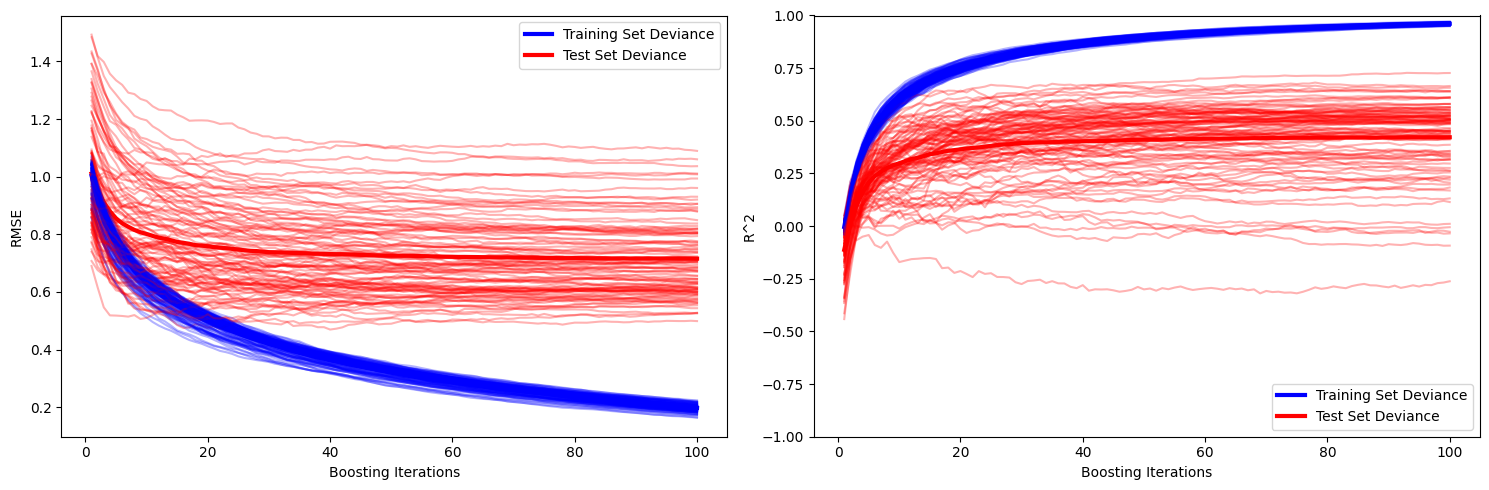

In [9]:
# Perform 100 independent runs of XGBoost using the best number of features with optimized hyperparameters
# Compute Shapley Values of the features

num_runs = 100

train_pred = []
test_pred = []
rmse_train = []
rmse_test = []
r2_train = []
r2_test = []
feat_imp = []
rmse_train_i = []
rmse_test_i = []
r2_train_i = []
r2_test_i = []

print("Computing %d xgboost ensembles (it will take a few seconds) ..." % num_runs)

for run in range(num_runs):
    #print(run)
    X_train, X_test, y_train, y_test = train_test_split(X_RFE, y, test_size=0.2, random_state=run+1)

    reg = xgb.XGBRegressor(**params_RFE, eval_metric=['rmse'], objective='reg:squarederror', random_state=run+1)
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
        )

    y_pred_train_i = [reg.get_booster().predict(xgb.DMatrix(X_train), iteration_range=(0, i)) for i in range(1,reg.get_num_boosting_rounds()+1)]
    y_pred_test_i = [reg.get_booster().predict(xgb.DMatrix(X_test), iteration_range=(0, i)) for i in range(1,reg.get_num_boosting_rounds()+1)]
    r2_train_i.append([r2_score(y_train, i) for i in y_pred_train_i])
    r2_test_i.append([r2_score(y_test, i) for i in y_pred_test_i])

    rmse_train_i.append(reg.evals_result()['validation_0']['rmse'])
    rmse_test_i.append(reg.evals_result()['validation_1']['rmse'])

    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
        
    rmse_train.append(mean_squared_error(y_train, y_pred_train, squared=False))
    r2_train.append(r2_score(y_train.flatten(), y_pred_train))
    rmse_test.append(mean_squared_error(y_test, y_pred_test, squared=False))
    r2_test.append(r2_score(y_test.flatten(), y_pred_test))

    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X_test)
    shap_values_means = np.nanmean(np.abs(shap_values), axis=0)
    feat_imp.append(shap_values_means/np.sum(shap_values_means))


rmse_train_i = np.array(rmse_train_i)
rmse_test_i = np.array(rmse_test_i)
r2_train_i = np.array(r2_train_i)
r2_test_i = np.array(r2_test_i)

rmse_train_ave = np.mean(rmse_train)
r2_train_ave = np.mean(r2_train)
rmse_test_ave = np.mean(rmse_test)
r2_test_ave = np.mean(r2_test)

feat_imp = np.array(feat_imp)
feat_imp_mean = feat_imp.mean(axis=0)
feat_imp_se = feat_imp.std(axis=0, ddof=1)/np.sqrt(num_runs)

spear_corr = np.array([np.nan_to_num(spearmanr(X_RFE[:,i], y).correlation) if (spearmanr(X_RFE[:,i], y).pvalue)<0.05 else 0. for i in range(len(traits_best_RFE))])

print("RMSE (train, test):", rmse_train_ave, rmse_test_ave)
print("R^2 (train, test):", r2_train_ave, r2_test_ave)

plot_mse_r2_training(rmse_train_i, rmse_test_i, r2_train_i, r2_test_i)

In [10]:
# Save workflow variables 
# It might overwrite previous files. Be sure to create a backup copy.

"""
results_to_store = {}

results_to_store["params_gridsearch"] = params
results_to_store["params_RFE_gridsearch"] = params_RFE
results_to_store["rmse_ave_RFE"] = rmse_ave_RFE
results_to_store["r2_ave_RFE"] = r2_ave_RFE
results_to_store["dict_traits"] = dict_traits_
results_to_store["x_RFE"] = x_RFE

with open("results_%s_shapley.json" % filename[:-4], 'w') as f:
    json.dump(results_to_store, f, indent=4)
f.close()
"""

'\nresults_to_store = {}\n\nresults_to_store["params_gridsearch"] = params\nresults_to_store["params_RFE_gridsearch"] = params_RFE\nresults_to_store["rmse_ave_RFE"] = rmse_ave_RFE\nresults_to_store["r2_ave_RFE"] = r2_ave_RFE\nresults_to_store["dict_traits"] = dict_traits_\nresults_to_store["x_RFE"] = x_RFE\n\nwith open("results_%s_shapley.json" % filename[:-4], \'w\') as f:\n    json.dump(results_to_store, f, indent=4)\nf.close()\n'

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


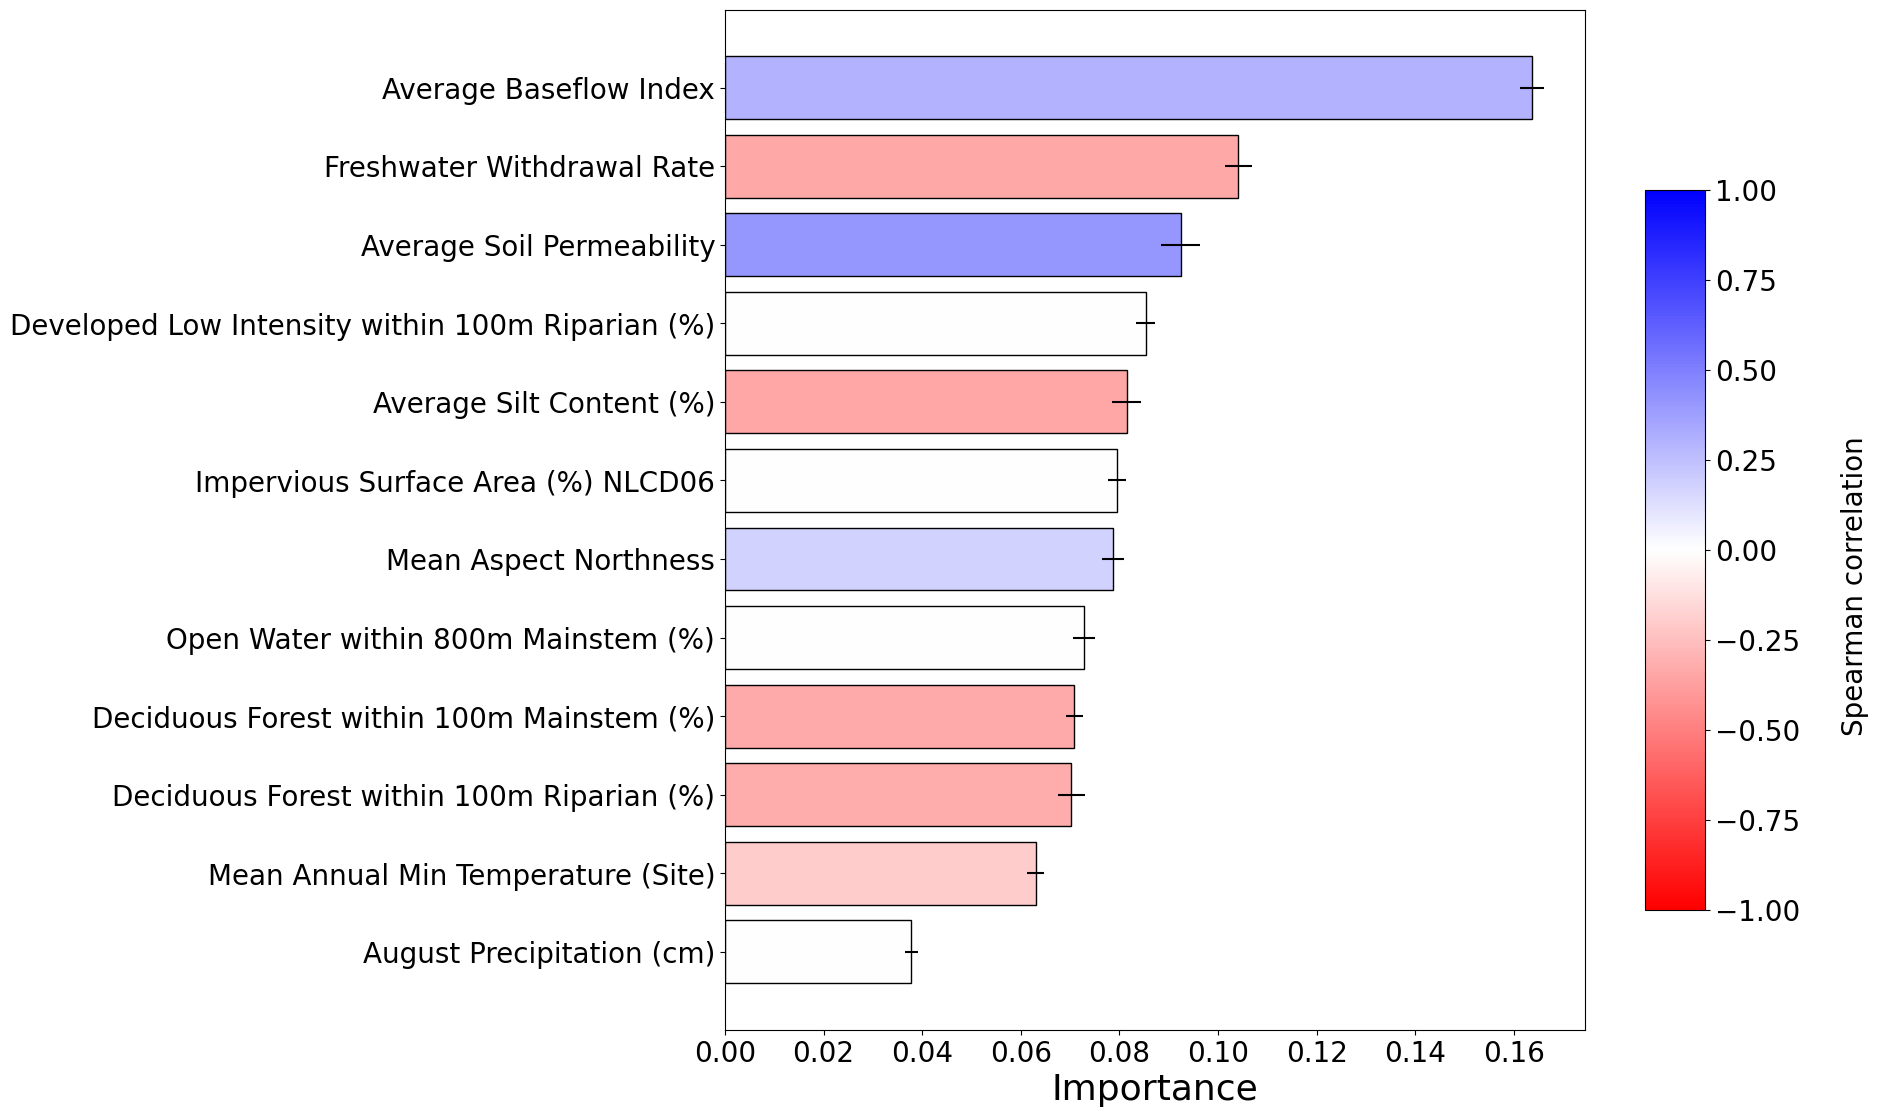

In [11]:
# Plot Shapley Values of best features

plot_importance_barchart(feat_imp_mean, feat_imp_se, spear_corr, filename,
    labels=np.array([dict_trait_names.get(x, x) for x in traits_best_RFE]),
    suffix="shapley")

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


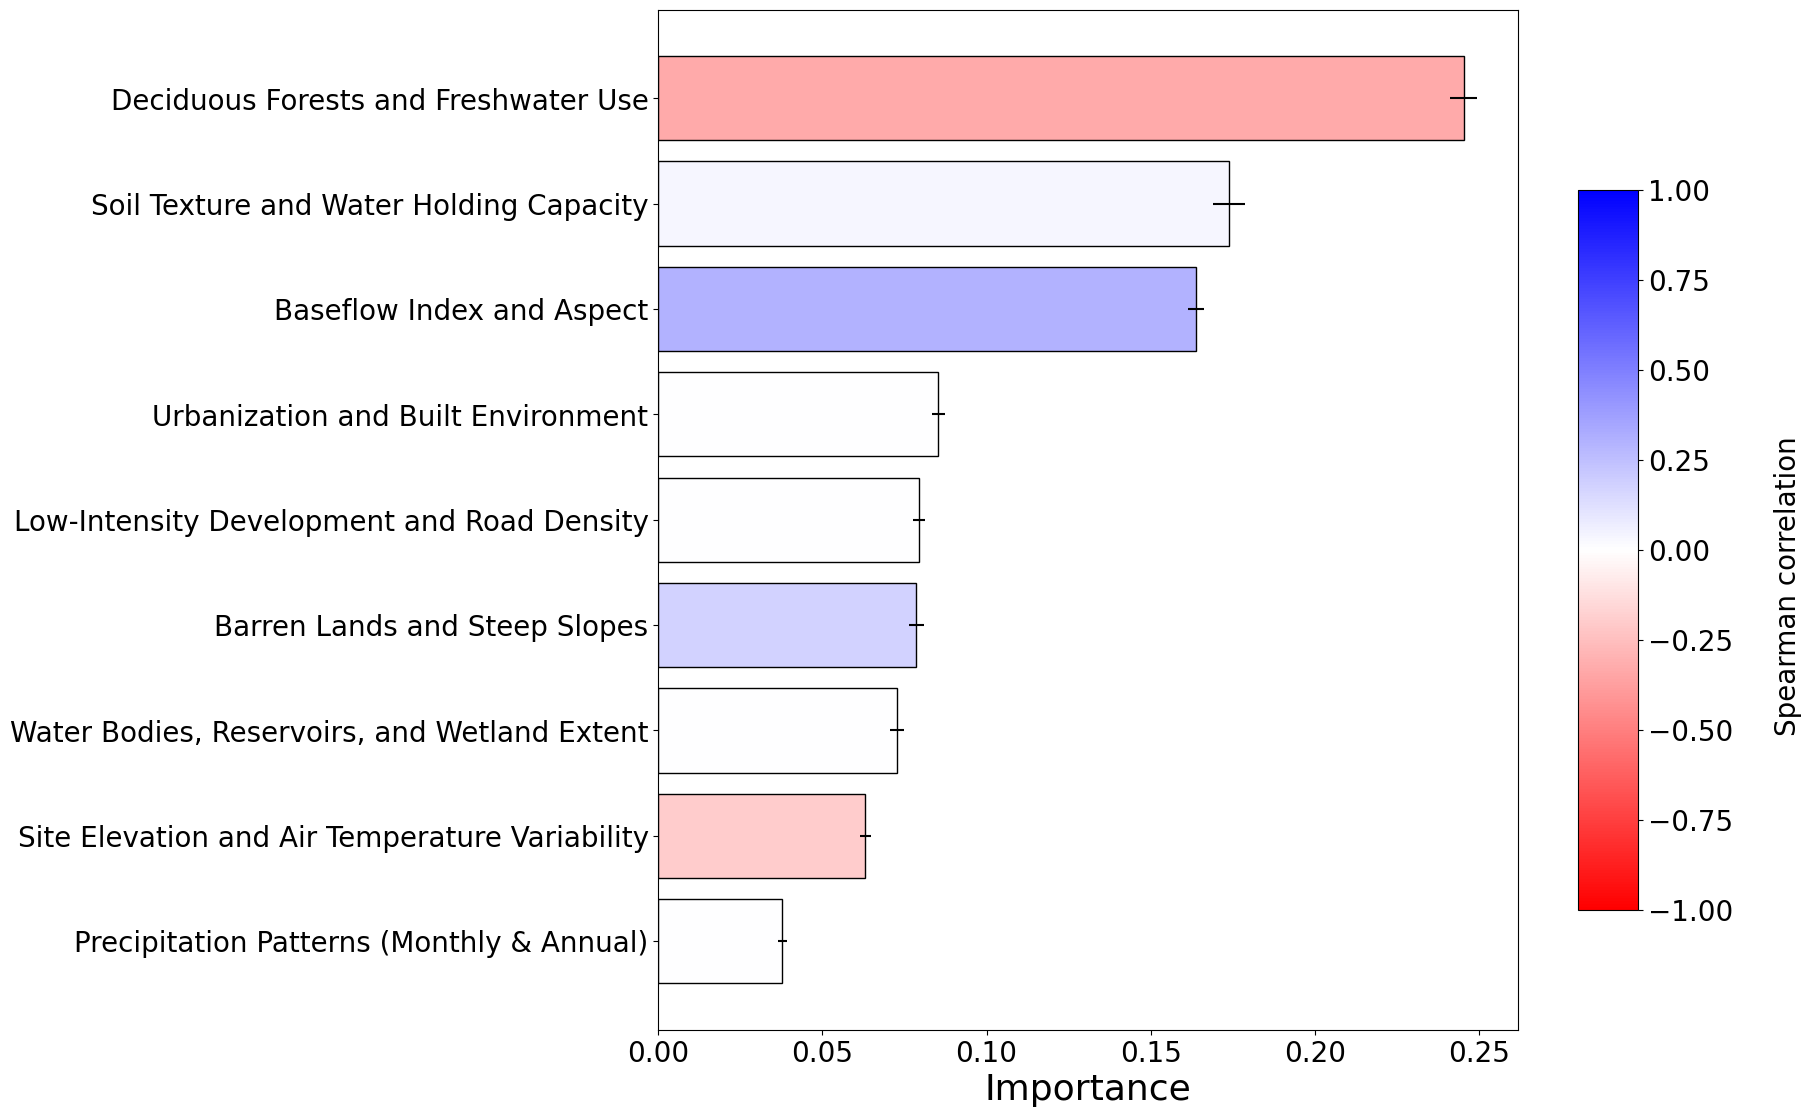

In [12]:
# Plot Shapley Values of category aggregated best features

df_imp_mean_agg = pd.DataFrame({'a':[traits_categories_labels[communities_attr[str(traits.tolist().index(i))]] for i in traits_best_RFE],
           'b':feat_imp_mean, 'c':feat_imp_se**2}).groupby('a').agg('sum')
df_imp_mean_agg['c'] = np.sqrt(df_imp_mean_agg['c'])

df_imp_corr_agg = pd.DataFrame({'a':[traits_categories_labels[communities_attr[str(traits.tolist().index(i))]] for i in traits_best_RFE],
           'b':spear_corr}).groupby('a').agg('mean')
feat_imp_mean_agg = df_imp_mean_agg['b'].values
feature_importance_se_agg = df_imp_mean_agg['c'].values
sp_corr_agg = df_imp_corr_agg['b'].values

plot_importance_barchart(feat_imp_mean_agg, feature_importance_se_agg, sp_corr_agg, filename,
    labels=df_imp_mean_agg.index.values,
     suffix='aggr_shapley')

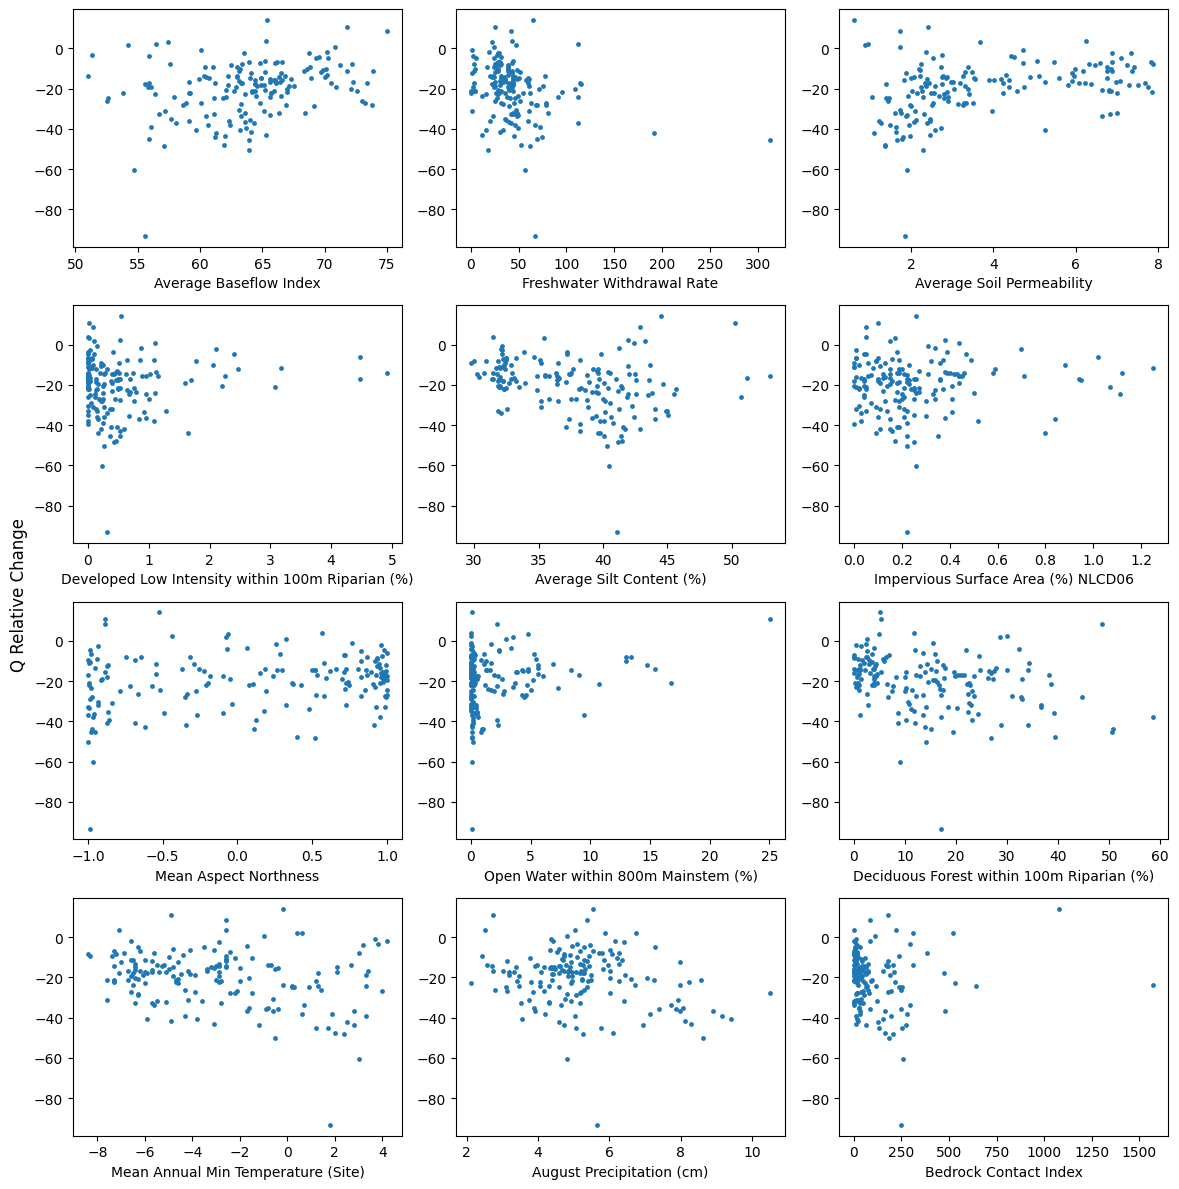

In [62]:
df_GAGESII_UCRB_QRelChangeMedian = pd.read_csv("drought_withnans_relchange_1-13-2025_all_nanmedian_noOutliers.csv")
fig, axs = plt.subplots(4, 3, facecolor="white", figsize=(12,12))
traits_to_scatterPlot = [x for x in traits_best_RFE[np.argsort(feat_imp_mean)[::-1]] if x!= 'MAINS100_41']+["CONTACT"]
for i,j in enumerate(traits_to_scatterPlot):
    axs[i//3][i%3].scatter(
        df_GAGESII_UCRB_QRelChangeMedian[j].values,
        df_GAGESII_UCRB_QRelChangeMedian["median"],
        s=6)
    axs[i//3][i%3].set_xlabel("%s" % dict_trait_names[j])
fig.supylabel("Q Relative Change")
plt.tight_layout()
plt.savefig("scatterplot_top_traits.png", dpi=600)
plt.show()